In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, activations
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
path_dir='F:/data/'
train_path = path_dir+'train_images'
train_batch_size = 100
val_batch_size = 20
IMAGE_SIZE_WIDTH = 1600
IMAGE_SIZE_HEIGHT = 256

In [5]:
import matplotlib.image as mpimg
from skimage.transform import resize

def load_image(infilename):
  """ Load an image from disk. """
  return mpimg.imread(infilename)

root_dir = "F:/data/"


image_dir = root_dir + "train_images/"
print(image_dir)



F:/data/train_images/


In [6]:
files = os.listdir(image_dir)
n = 100
#*2//3

print("Loading " + str(n) + " images")

tt=[load_image(image_dir + files[i]) for i in range(n)]
print(len(tt))

X = np.asarray(tt)
print(X.shape)

gt_dir = root_dir + "3/"
print("Loading " + str(n) + " images")
gt_imgs = np.asarray([load_image(gt_dir + files[i]) for i in range(n)])

Loading 100 images
100
(100, 256, 1600, 3)
Loading 100 images


In [7]:
img_data_list = [] 
labels_list = []

import cv2

img_data_list = [] 
labels_list = []
for i in range(n):
    input_img=cv2.imread(gt_dir + files[i])
    input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    #mask = img_to_array(load_img(path_train + '//masks//' + id_, grayscale=False))
    input_img = resize(input_img, (256,1600,1), mode='constant', preserve_range=True)
    #input_img_resize=cv2.resize(input_img,(128,128))
    img_data_list.append(input_img)
    #labels_list.append(label)

C:\Users\Aniket\AppData\Local\conda\conda\envs\opencv\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [8]:
y = np.array(img_data_list)
y = y.astype('float32')
y /= 255
print (y.shape)

(100, 256, 1600, 1)


In [14]:
smooth = 1.
img_rows = 256
img_cols = 1600

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall))


def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def up_conv_block(input_tensor, kernel_size, filters, stage, block, strides=(1, 1)):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    up_conv_name_base = 'up' + str(stage) + block + '_branch'
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = UpSampling2D(size=(2, 2), name=up_conv_name_base + '2a')(input_tensor)

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(x)

    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = UpSampling2D(size=(2, 2), name=up_conv_name_base + '1')(input_tensor)
    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(shortcut)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def get_resnet(f=16, bn_axis=3, classes=1):
    input = Input((img_rows, img_cols, 3))
    x = ZeroPadding2D((4, 4))(input)
    x = Conv2D(f, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [f, f, f * 2], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [f, f, f * 2], stage=2, block='b')
    x2 = identity_block(x, 3, [f, f, f * 2], stage=2, block='c')

    x = conv_block(x2, 3, [f * 2, f * 2, f * 4], stage=3, block='a')
    x = identity_block(x, 3, [f * 2, f * 2, f * 4], stage=3, block='b')
    x3 = identity_block(x, 3, [f * 2, f * 2, f * 4], stage=3, block='d')

    x = conv_block(x3, 3, [f * 4, f * 4, f * 8], stage=4, block='a')
    x = identity_block(x, 3, [f * 4, f * 4, f * 8], stage=4, block='b')
    x4 = identity_block(x, 3, [f * 4, f * 4, f * 8], stage=4, block='f')

    x = conv_block(x4, 3, [f * 8, f * 8, f * 16], stage=5, block='a')
    x = identity_block(x, 3, [f * 8, f * 8, f * 16], stage=5, block='b')
    x = identity_block(x, 3, [f * 8, f * 8, f * 16], stage=5, block='c')

    x = up_conv_block(x, 3, [f * 16, f * 8, f * 8], stage=6, block='a')
    x = identity_block(x, 3, [f * 16, f * 8, f * 8], stage=6, block='b')
    x = identity_block(x, 3, [f * 16, f * 8, f * 8], stage=6, block='c')

    x = concatenate([x, x4], axis=bn_axis)

    x = up_conv_block(x, 3, [f * 16, f * 4, f * 4], stage=7, block='a')
    x = identity_block(x, 3, [f * 16, f * 4, f * 4], stage=7, block='b')

    x = identity_block(x, 3, [f * 16, f * 4, f * 4], stage=7, block='f')

    x = concatenate([x, x3], axis=bn_axis)

    x = up_conv_block(x, 3, [f * 8, f * 2, f * 2], stage=8, block='a')
    x = identity_block(x, 3, [f * 8, f * 2, f * 2], stage=8, block='b')
    x = identity_block(x, 3, [f * 8, f * 2, f * 2], stage=8, block='d')

    x = concatenate([x, x2], axis=bn_axis)

    x = up_conv_block(x, 3, [f * 4, f, f], stage=10, block='a', strides=(1, 1))
    x = identity_block(x, 3, [f * 4, f, f], stage=10, block='b')
    x = identity_block(x, 3, [f * 4, f, f], stage=10, block='c')

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(classes, (3, 3), padding='same', activation='sigmoid', name='convLast')(x)

    model = Model(input, x, name='resnetUnet')
    model.compile(optimizer=Adam(lr=3e-4), loss=dice_coef_loss,
                  metrics=[dice_coef, 'accuracy', precision, recall, f1score])

    model.summary()

    return model


In [1]:
from keras import models
from keras.layers.core import Activation, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
import json

img_w = 1600
img_h = 256
n_labels = 4


def build_model():

    kernel = 3

    encoding_layers = [
        Convolution2D(64, kernel, border_mode='same', input_shape=( img_h, img_w,3)),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(64, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),

        Convolution2D(128, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(128, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),

        Convolution2D(256, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(256, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(256, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),

        Convolution2D(512, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(512, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(512, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),

        Convolution2D(512, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(512, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(512, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(),
    ]

    autoencoder = models.Sequential()
    autoencoder.encoding_layers = encoding_layers

    for l in autoencoder.encoding_layers:
        autoencoder.add(l)
        print(l.input_shape,l.output_shape,l)

    decoding_layers = [
        UpSampling2D(),
        Convolution2D(512, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(512, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(512, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),

        UpSampling2D(),
        Convolution2D(512, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(512, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(256, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),

        UpSampling2D(),
        Convolution2D(256, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(256, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(128, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),

        UpSampling2D(),
        Convolution2D(128, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(64, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),

        UpSampling2D(),
        Convolution2D(64, kernel, kernel, border_mode='same'),
        BatchNormalization(),
        Activation('relu'),
        Convolution2D(n_labels, 1, 1, border_mode='valid'),
        BatchNormalization(),
    ]
    autoencoder.decoding_layers = decoding_layers
    for l in autoencoder.decoding_layers:
        autoencoder.add(l)

    with open('model_5l.json', 'w') as outfile:
        outfile.write(json.dumps(json.loads(autoencoder.to_json()), indent=2))

    return autoencoder

Using TensorFlow backend.


In [10]:
import os

import numpy as np
from keras import backend as K
from keras import layers
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.layers import Activation
from keras.layers import Input, Conv2D, ZeroPadding2D, MaxPooling2D, UpSampling2D, concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from skimage.io import imsave

from keras.callbacks import ModelCheckpoint, CSVLogger

model = build_model()

bit=8


csv_logger = CSVLogger('log_resnet_' + str(bit) + '.csv')
model_checkpoint = ModelCheckpoint('weights_resnet_' + str(bit) + '.h5', monitor='val_loss', save_best_only=True)

print('-' * 30)
print('Fitting model (bit = ' + str(bit) + ') ...')
print('-' * 30)



C:\Users\Aniket\AppData\Local\conda\conda\envs\opencv\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, 3, padding="same", input_shape=(256, 1600...)`
C:\Users\Aniket\AppData\Local\conda\conda\envs\opencv\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, 3, padding="same")`
C:\Users\Aniket\AppData\Local\conda\conda\envs\opencv\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
C:\Users\Aniket\AppData\Local\conda\conda\envs\opencv\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
C:\Users\Aniket\AppData\Local\conda\conda\envs\opencv\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`
C:\Users\A

(None, 256, 1600, 3) (None, 256, 1600, 64) <keras.layers.convolutional.Conv2D object at 0x0000023108D82208>
(None, 256, 1600, 64) (None, 256, 1600, 64) <keras.layers.normalization.BatchNormalization object at 0x0000023108D82518>
(None, 256, 1600, 64) (None, 256, 1600, 64) <keras.layers.core.Activation object at 0x0000023108D82630>
(None, 256, 1600, 64) (None, 256, 1600, 64) <keras.layers.convolutional.Conv2D object at 0x0000023108D82668>
(None, 256, 1600, 64) (None, 256, 1600, 64) <keras.layers.normalization.BatchNormalization object at 0x0000023108D82710>
(None, 256, 1600, 64) (None, 256, 1600, 64) <keras.layers.core.Activation object at 0x0000023108D82908>
(None, 256, 1600, 64) (None, 128, 800, 64) <keras.layers.pooling.MaxPooling2D object at 0x0000023108D82940>
(None, 128, 800, 64) (None, 128, 800, 128) <keras.layers.convolutional.Conv2D object at 0x0000023108D829E8>
(None, 128, 800, 128) (None, 128, 800, 128) <keras.layers.normalization.BatchNormalization object at 0x0000023108D82A

C:\Users\Aniket\AppData\Local\conda\conda\envs\opencv\lib\site-packages\ipykernel_launcher.py:76: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="same")`
C:\Users\Aniket\AppData\Local\conda\conda\envs\opencv\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="same")`
C:\Users\Aniket\AppData\Local\conda\conda\envs\opencv\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="same")`
C:\Users\Aniket\AppData\Local\conda\conda\envs\opencv\lib\site-packages\ipykernel_launcher.py:87: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="same")`
C:\Users\Aniket\AppData\Local\conda\conda\envs\opencv\lib\site-packages\ipykernel_launcher.py:90: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="same")`
C:\Users\Aniket\AppData\L

------------------------------
Fitting model (bit = 8) ...
------------------------------


mkl-random 1.0.1 requires cython, which is not installed.
tensorflow 1.10.0 has requirement numpy<=1.14.5,>=1.13.3, but you'll have numpy 1.15.2 which is incompatible.
tensorflow 1.10.0 has requirement setuptools<=39.1.0, but you'll have setuptools 40.2.0 which is incompatible.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


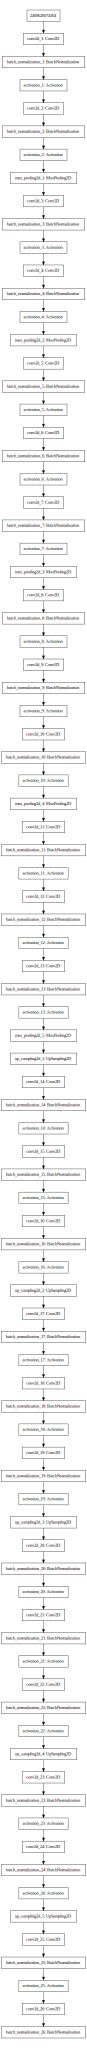

In [11]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import os
os.environ["PATH"] += os.pathsep + '''C:/Program Files (x86)/Graphviz2.38/bin/'''

!pip install graphviz
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [12]:
from keras.utils import plot_model
plot_model(model, to_file='SEG.png')

In [ ]:

model.compile(optimizer=Adam(lr=3e-4), loss=dice_coef_loss,
                  metrics=[dice_coef, 'accuracy', precision, recall, f1score])

from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)


model.fit(X_train, y_train, batch_size=32, epochs=2, verbose=1, shuffle=True,
          callbacks=[csv_logger, model_checkpoint])


Epoch 1/2
